# Python for Finance
## Assignment 1

### Data setup and preparation:
Loading the files and cleaning data etc. Goes here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy
import scipy.stats
import os

In [2]:
PROJECT_ROOT_DIR = "./"
DATA_DIR = "data"

In [3]:
path = os.path.join(PROJECT_ROOT_DIR, DATA_DIR, "crsp")

In [4]:
# Load data
# CRSP
crsp = pd.read_csv(os.path.join(path, "crsp.csv"), low_memory=False)
# FF
ff = pd.read_csv(os.path.join(path, "ff3.csv"))

_Number of missing data in crsp is relatively small in comparison with the number of instances (around 1%). Thus NaN data is dropped.
All columns in ff contain the same number of instances, and all non-date are floats._

In [5]:
# Format data
# CRSP
crsp.dropna(inplace=True)
crsp.date = pd.to_datetime(crsp.date, format='%Y%m%d')
crsp['retf'] = crsp.RET
crsp['retf'].replace('C',np.NaN, inplace=True)
crsp['retf'] = pd.to_numeric(crsp['retf'],downcast='float')
# FF
ff.dateff = pd.to_datetime(ff.dateff, format='%Y%m%d')

In [6]:
# Only industries that are used in the following are added to the dictionary
industries = {
            "1000-1499":"Mining",
            "1500-1799":"Construction",
            "2000-3999":"Manufacturing",
            "4000-4999":"Transportation, Communications, Electric, Gas and Sanitary service",
            "5000-5199":"Wholesale Trade",
            "5200-5999":"Retail Trade",
            "6000-6799":"Finance, Insurance and Real Estate",
            "7000-8999":"Services"
         }

In [7]:
# Changes SICCD to numeric and drops non-numeric ones
crsp.SICCD = pd.to_numeric(crsp['SICCD'],downcast='integer',errors="coerce")
crsp.dropna(inplace=True)

# Creates a new column 'industry' and sets all to 0, which is the "drop" sign later
crsp["industry"] = 0

for count, key in enumerate(industries, 1): #Starts at 1 so all reamaining will be dropped
    low  = int(key.split("-")[0])
    high = int(key.split("-")[1])
    crsp.loc[(crsp.SICCD >= low) & (crsp.SICCD <= high), "industry"] = count

# Only keeps necessary industries
crsp = crsp[crsp['industry'] != 0]

In [8]:
# Merge crsp and ff in a new dataframe
ap_data = pd.merge(crsp,ff,left_on="date",right_on="dateff")
ap_data['eri'] = ap_data.retf - ap_data.rf
# A counter for the firms, will be used later
ap_data["nfirm"] = 1

### Question 1

**1. Make a table that outlines the performance and characteristics of each of the remaining industry portfolios:**
 - Average return, Volatility, Beta (CAPM), Sharpe-ratio, average number of firms in each industry portfolio.

In [9]:
def annualize(mon_ret):
    "Returns annualized returns given monthly returns"
    return ((1+mon_ret)**12-1)

In [10]:
# Answer table is where, you guessed, the table with answers is stored
# Adds the ANNUALIZED returs per industry
answer_table = pd.DataFrame(ap_data.groupby("industry").retf.mean()).apply(annualize)
# Changes name of column
answer_table.columns = ["Avg_return"]

In [11]:
# Annualized risk free rate averaged over the whole series
rf_avg = annualize(ap_data.groupby("date").mean().rf.mean())

In [12]:
# Loops over the different industries that are listed in the index of answer_table
for industry in answer_table.index:
    
    #Volatility
    std_mon = ap_data[ap_data["industry"] == industry].groupby("date").mean().retf.std()
    std_ann = std_mon * np.sqrt(12) #Annualized
    
    ## CAPM Beta
    capm = ols("eri ~ mktrf", ap_data.loc[ap_data.industry == industry])
    est  = capm.fit()
    beta = est.params[1]
    
    # Sharpe ratio    
    sharpe = (answer_table.loc[industry, "Avg_return"] - rf_avg) / std_ann
    
    # Average number of firms
    nfirms = ap_data[ap_data["industry"] == industry].groupby("date").sum().nfirm.mean()
    
    # Puts data into answer sheet
    answer_table.loc[industry, "Volatility"] = std_ann
    answer_table.loc[industry, "Beta"] = beta
    answer_table.loc[industry, "Sharpe_ratio"] = sharpe
    answer_table.loc[industry, "Avg_nfirms"] = nfirms
    answer_table.loc[industry, "Name"] = list(industries.values())[industry-1]

In [13]:
cols = answer_table.columns.tolist()
cols = cols[-1:] + cols[:-1]
answer_table = answer_table[cols]

**Answer 1.1**

In [14]:
answer_table

,Name,Avg_return,Volatility,Beta,Sharpe_ratio,Avg_nfirms
industry,,,,,,
1,Mining,0.147413,0.248606,1.118080,0.543680,16.867647
2,Construction,0.145133,0.311500,1.386604,0.426590,4.985294
3,Manufacturing,0.154795,0.165146,1.117067,0.863139,188.450980
4,"Transportation, Communications, Electric, Gas ...",0.129327,0.151276,0.912882,0.773924,66.921569
5,Wholesale Trade,0.130328,0.160199,0.869932,0.737070,13.392157
6,Retail Trade,0.161272,0.183955,1.015156,0.810095,35.166667
7,"Finance, Insurance and Real Estate",0.134184,0.192652,1.165674,0.632918,97.102941
8,Services,0.193985,0.184153,1.192360,0.986862,65.872549


_In the table above we can see the Average return of each industry portfolio in the second column. The Volatility and Beta are listed in the third and fourth column. Notice that "Transportation, Communications, Electric, Gas and Sanitary service" and "Wholsesale Trade" have betas below 1, indicating that they can be considered less risky than the market index. The "Sharpe ratio" column contains the average Sharpe ratio of each industry portfolio. The Sharpe ratio can be used to determine what is the risk-return relation of each portfolio. Notice that the "Services" industry has the highest Sharpe ratio._

**2. Create your own equally weighted index from the different industry portfolios. Give each industry an equal weight in each period.**

In [15]:
dates = ap_data.date.unique()
dates = np.sort(dates)
data       = {'date': dates}
ind_ret = pd.DataFrame(data)
ind_ret.set_index("date", inplace=True)

# Calculates cumreturn for each industry
for industry in answer_table.index:
    ind_ret[str(industry)] = ap_data[ap_data["industry"] == industry].groupby("date").mean().retf

# Adds industry equally weighted index as "Avg"
ind_ret["Avg"] = ap_data.groupby(["date","industry"]).mean().groupby("date").mean().retf

We will create an index for each portfolio that starts at 100 in the first day of the first month of the timeseries.

In [16]:
# Indexes of all portfolios start at 100
ind_100 = (100+((1+ind_ret).cumprod()-1)*100)

**Answer 1.2**

In [17]:
# renames columns from numbers to actual names
ind_100.rename(columns={'1':"Mining",
            '2':"Construction",
            '3':"Manufacturing",
            '4':"Transportation, Communications, Electric, Gas and Sanitary service",
            '5':"Wholesale Trade",
            '6':"Retail Trade",
            '7':"Finance, Insurance and Real Estate",
            '8':"Services",
            'Avg':"Market Index"}, inplace=True)
ind_100.head()

,Mining,Construction,Manufacturing,"Transportation, Communications, Electric, Gas and Sanitary service",Wholesale Trade,Retail Trade,"Finance, Insurance and Real Estate",Services,Market Index
date,,,,,,,,,
2002-01-31,97.292923,106.299446,101.365639,96.680557,106.129417,105.550552,100.217834,97.416290,101.369080
2002-02-28,103.617035,115.031143,101.400497,91.909012,107.797325,105.271996,101.612045,95.162300,102.661339
2002-03-28,114.641380,113.414444,106.646034,100.886497,110.568039,108.961884,108.056168,104.568741,108.625557
2002-04-30,116.232384,117.961502,103.549469,96.253922,114.768234,113.964104,109.121994,97.251480,108.663559
2002-05-31,115.966812,109.336601,103.089371,92.157791,114.358757,114.653992,108.007629,95.523697,106.654739


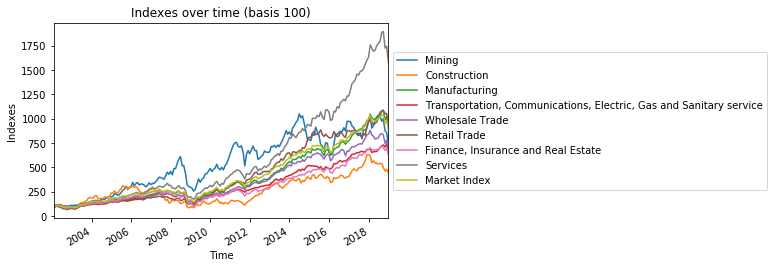

In [18]:
ind_100.plot()
plt.title("Indexes over time (basis 100)")
plt.xlabel('Time')
plt.ylabel('Indexes')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

The table above shows the base 100 index of each individual industry as well as a market index (equally weighted average of industry portfolios) over time.

**3. Plot the cumulative returns of the industry portfolios over time as well as your own index in a graph.**

#### Answer 1.3

Almost the same as above, besides instead of basis 100, we only use returns

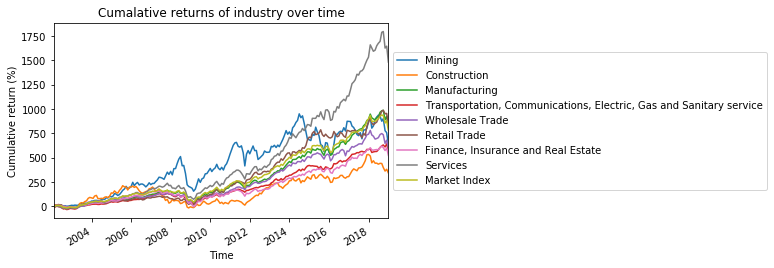

In [19]:
(((1+ind_ret).cumprod()-1)*100).plot()
plt.title("Cumalative returns of industry over time")
plt.xlabel('Time')
plt.ylabel('Cumulative return (%)')
plt.legend([str(i) for i in ind_100.columns],loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

**4. Regress the industry portfolio returns against the Fama-French 3 factor model. What risk factors are you exposed to and to what degree? Do you generate a positive and significant alpha in any of the industry portfolios?**

In [20]:
# Calculates excess returns and add to ff dataset (as this only has one isntance per month)
ff["ret"] = ind_ret.Avg.values - ff.rf

#### Answer 1.4

For the market portfolio:

In [21]:
# Regression
ff_reg = ols("ret ~ mktrf + smb + hml", ff)
est = ff_reg.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     801.6
Date:                Sat, 05 Oct 2019   Prob (F-statistic):          3.64e-111
Time:                        11:16:09   Log-Likelihood:                 590.57
No. Observations:                 204   AIC:                            -1173.
Df Residuals:                     200   BIC:                            -1160.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.001      4.479      0.0

_In the all industries portfolio, all factors are significant. That would indicate that in our analysis, the industry portfolio is exposed to all three factors of ff3. Particularly the market risk factor is significant at a relatively higher level. The adjusted R-squared value is close to 1.0, indicating that our model explains a high degree of the variability of the dependent variable._

For each portfolio:

In [22]:
tthres = 1.96 #Threshold for significant t-value at 5%

for industry in answer_table.index:
    ff["ind_ret"] = ind_ret[str(industry)].values - ff.rf
    
    # Regression for each industry return
    ff_reg = ols("ind_ret ~ mktrf + smb + hml", ff)
    est = ff_reg.fit()
    
    print("For industry {}".format(answer_table.Name[industry]))
    print("These are the significant factors at the 5% confidence level:")
    
    signif = (est.tvalues[abs(est.tvalues) > tthres].index)
    for idx in signif:
        print ("{:<10s} : {:>5.2f}".format(idx, est.params[est.params.index == idx].values[0]))
    
    print ()

For industry Mining
These are the significant factors at the 5% confidence level:
mktrf      :  1.02
smb        :  0.45
hml        :  0.32

For industry Construction
These are the significant factors at the 5% confidence level:
mktrf      :  1.16
smb        :  0.83
hml        :  0.65

For industry Manufacturing
These are the significant factors at the 5% confidence level:
Intercept  :  0.00
mktrf      :  1.08
smb        :  0.22

For industry Transportation, Communications, Electric, Gas and Sanitary service
These are the significant factors at the 5% confidence level:
Intercept  :  0.00
mktrf      :  0.90

For industry Wholesale Trade
These are the significant factors at the 5% confidence level:
Intercept  :  0.00
mktrf      :  0.79
smb        :  0.33

For industry Retail Trade
These are the significant factors at the 5% confidence level:
Intercept  :  0.01
mktrf      :  0.92
smb        :  0.44
hml        :  0.19

For industry Finance, Insurance and Real Estate
These are the significan

* In all cases, the most important risk to each portfolio is the market risk factor. 
* The largest significant value of 'small minus big' and 'high beta minus low beta' appears in Construction 0.83 and 0.65, respectively.
* But in general, the above two parameters are much smaller than the market risk factor.
* When significant, factors always have a positive effect on returns, with the exception of hml in Services.

In [23]:
print ("Sectors with alpha positive and significant at the 5% confidence level: \n")

for industry in answer_table.index:
    ff["ind_ret"] = ind_ret[str(industry)].values - ff.rf
    
    # Regression for each industry return
    ff_reg = ols("ind_ret ~ mktrf + smb + hml", ff)
    est = ff_reg.fit()
    
    # If tvalue of alpha is significant and positive:
    if est.tvalues[0] > 1.96 and est.params[0] > 0:
        print(answer_table.Name[industry])
        print("Alpha   = {:>4.2%}".format(est.params[0]))
        print("t-value = {:>4.2f}".format(est.tvalues[0]))
        print()

Sectors with alpha positive and significant at the 5% confidence level: 

Manufacturing
Alpha   = 0.44%
t-value = 5.81

Transportation, Communications, Electric, Gas and Sanitary service
Alpha   = 0.40%
t-value = 2.55

Wholesale Trade
Alpha   = 0.44%
t-value = 2.17

Retail Trade
Alpha   = 0.52%
t-value = 2.40

Services
Alpha   = 0.68%
t-value = 5.39



### Question 2

**Imagine that you are a naïve investor in the year 2003. You decide to start saving some extra money for your retirement. You decide to save 300 Euro per month: 100 euro in each of the three best performing industry portfolios from Question 1 over the preceding 12 months. You always look back 12 months at the end of each month to determine which industries to invest in.
Thus, at the beginning of each month you need to decide where to invest your new money. The money already invested stays in the industry where it was initially invested. This means that you will poten-tially hold several different industry portfolios at the same time.**
1. How is your money distributed over the different industries at the end of 2018?
    * Plot the distribution at the end of 2018
    * Plot the development of the value of your different investments in the different industry portfolios over time.
2. What is your total capital gain in % over the total amount invested at the end of 2018?
3. What is your average annual return from this strategy?
4. What if you used a 6 month formation period for your new investments instead of 12 months, how would the results change? [Hint for full points: Write a function that allows you to change parameters to compute the outcome for different formation periods instead of copy-pasting the code.]

In [24]:
def naive_portfolio(df, t_form = 12):
    """
    Inputs
        df     : Data Frame containing the monthly indexes returns
        t_form : Formation period of strategy
    Output
        Final composition and position sizes over time as plots
        Capital gains
        Average annual return
    """
    
    # Return of indexes + 1
    ind_ret1 = df.drop("Avg", axis=1) + 1 
    
    # Creates a portfolio df where positions are gonna be stored
    portfolios = pd.DataFrame(0, index=ind_ret.index, columns=ind_ret.columns)
    portfolios.rename(columns={"Avg":"Total"}, inplace=True)
    portfolios["Cum_invest"] = 0  #Keeps total invested in portfolio
    portfolios["Return"]   = 0  #Calculates monthly returns
    portfolios.reset_index(inplace=True)
    
    #columns with indexes from df
    num_port = [str(i) for i in range(1,9)] 

    for idx, row in portfolios.iloc[t_form:].iterrows():

        # After initial formation period -> create dataframe with formation sample returns
        form_sample = ind_ret1[(ind_ret1.index < portfolios.date[idx]) & (ind_ret1.index >= portfolios.date[idx - t_form])]
        # Calculate average returns of individual indexes during ante period
        avg_ret     = form_sample.agg('prod')
        # Sort those returns
        ret_sort    = avg_ret.sort_values(ascending=False)
        # Get only the top 3 positions
        top3        = ret_sort.index.values[:3]

        # Ammount of money in each index from previous month
        portfolios.loc[idx, num_port] = portfolios.loc[idx-1, num_port]
        # Adds 100 bucks in the top 3
        portfolios.loc[idx, top3] = portfolios.loc[idx-1, top3] + 100

        # Cumulative investments
        portfolios.loc[idx, "Cum_invest"] = portfolios.loc[idx-1, "Cum_invest"] + 300

        # Monthly return of indexes
        mon_ret = ind_ret1[(ind_ret1.index == portfolios.date[idx])].agg('prod')
        # Money at the end of the month (after month's index returns)
        portfolios.loc[idx, num_port] = portfolios.loc[idx, num_port] * mon_ret
        
        # Total portfolio at the end of the month
        portfolios.loc[idx, "Total"] = portfolios.loc[idx, num_port].sum()
        # Return at end of the month
        portfolios.loc[idx, "Return"] = portfolios.loc[idx, "Total"] / (portfolios.loc[idx-1, "Total"] + 300) - 1
    
    ############### PLOTS ##################
    # Plots distribution of portfolio in the end of period
    fig, ax = plt.subplots(figsize=(8,6))
    portfolios.set_index("date")[num_port].iloc[-1].plot.bar(color="b")

    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i, ind in enumerate(answer_table["Name"]):
        labels[i] = ind.split(",")[0]
    
    ax.set_title("Composition of naive portfolio at the end of 2018")
    ax.set_ylabel('Size (€)')
    ax.set_xticklabels(labels)
    plt.show()
    
    
    # Plots development of portfolio over time
    portfolios.set_index("date")[num_port].plot(figsize=(8,6))
    plt.title("Composition of portfolio over time")
    plt.ylabel('Portfolio size (€)')
    plt.legend([str(i) for i in answer_table.Name],loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()
    
    
    ############### INFOS ###################
    print()
    print("Capital gains: {:>5.1%}".format(portfolios.Total.iloc[-1] / portfolios.Cum_invest.iloc[-1]))
    print()
    print("Avg Ann Return: {:>5.1%}".format(annualize(portfolios.iloc[t_form:].Return.mean())))

#### Answers 2.1 to 2.3

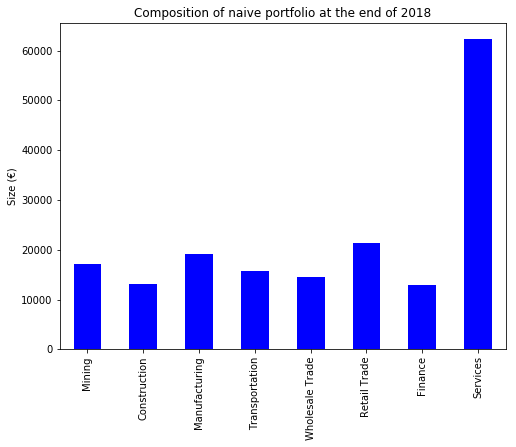

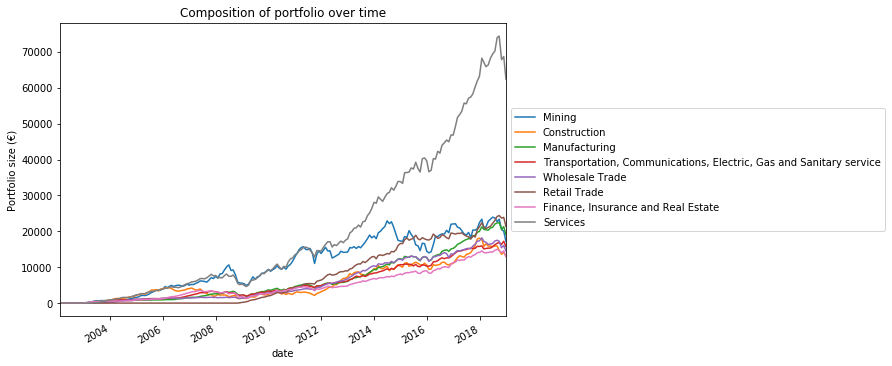


Capital gains: 306.2%

Avg Ann Return: 16.1%


In [25]:
# with 12 months
t_form = 12
naive_portfolio(ind_ret, t_form)

#### Answers 2.4

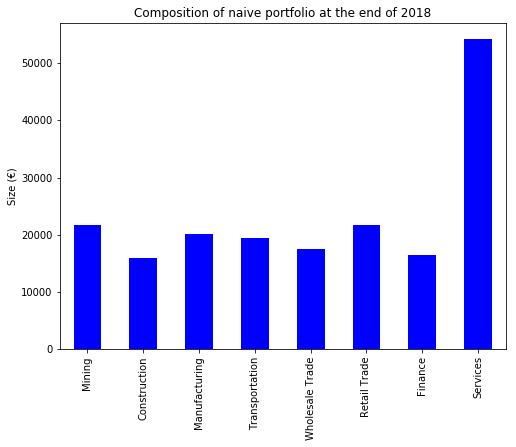

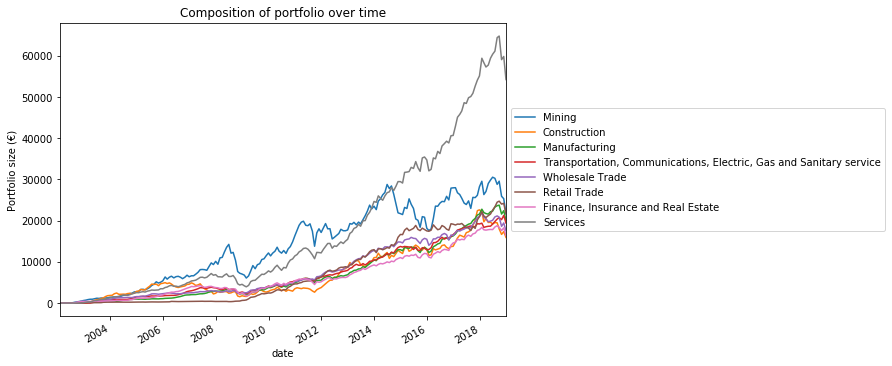


Capital gains: 314.9%

Avg Ann Return: 14.8%


In [26]:
# with 6 months
t_form = 6
naive_portfolio(ind_ret, t_form)

Average Annual Return would be lower, but capital gains higher.

### Question 3

**Imagine that you do not want to use your own money to invest (unlike in Question 2). As a result, you decide to use a long-short portfolio strategy. Each quarter go long the best performing industry portfolio and short the worst performing industry over the last 3 months with 300 euros each. Already invested money (both long and short) stays in the respective portfolio until the end of 2018. Thus, just like in the previous question you add 300 eur a month but this time you finance it by selling shares worth 300 euros as well.**
* How much money will you have amassed at the end of 2018 after repaying all short positions?
* What is your average annual return of the long-short portfolio?

In [27]:
def long_short_portfolio(df, t_form = 3, t_hold = 3):
    """
    Inputs
        df     : Data Frame containing the monthly indexes returns
        t_form : Formation period of strategy
        t_hold : Holding period of strategy
    Returns
        Long and Short portfolios over time
    """
    # Return of indexes + 1
    ind_ret1 = df.drop("Avg", axis=1) + 1

    # Creates a portfolio df where positions are gonna be stored
    port_long = pd.DataFrame(0, index=ind_ret.index, columns=ind_ret.columns)
    port_long.rename(columns={"Avg":"Total"}, inplace=True)
    port_long["Return"]   = 0  #Calculates monthly returns
    port_long.reset_index(inplace=True)

    rep_seq = list(range(0, t_form))*round(((len(ind_ret1)) / t_form)+0.5)
    port_long['m'] = rep_seq[:len(ind_ret1)]

    # Now creates long and short only portfolios
    port_short = port_long.copy()

    #columns with indexes from df
    num_port = [str(i) for i in range(1,9)] 

    for idx, row in port_long[t_form:].iterrows():

        # Ammount of money in each index from previous month
        port_short.loc[idx, num_port] = port_short.loc[idx-1, num_port]
        port_long.loc[idx, num_port] = port_long.loc[idx-1, num_port]

        # Monthly return of indexes
        mon_ret = ind_ret1[(ind_ret1.index == port_long.date[idx])].agg('prod')

        if row.m == 0:
            # After initial formation period -> create dataframe with formation sample returns
            form_sample = ind_ret1[(ind_ret1.index < port_long.date[idx]) & (ind_ret1.index >= port_long.date[idx - t_form])]
            # Calculate average returns of individual indexes during ante period
            avg_ret     = form_sample.agg('prod')
            # Sort those returns
            ret_sort    = avg_ret.sort_values(ascending=False)
            # Get only the top position
            top1        = ret_sort.index.values[0]
            # Get only the bottom position
            low1        = ret_sort.index.values[-1]

            # Sells short 300 bucks in the bottom 1 and goes long 300 bucks in top 1
            port_short.loc[idx, low1] = port_short.loc[idx-1, low1] - 300
            port_long.loc[idx, top1] = port_long.loc[idx-1, top1] + 300

            # Money at the end of the month (after month's index returns)
            port_short.loc[idx, num_port] = port_short.loc[idx, num_port] * mon_ret
            port_long.loc[idx, num_port] = port_long.loc[idx, num_port] * mon_ret

            # Total portfolio at the end of the month
            port_short.loc[idx, "Total"] = port_short.loc[idx, num_port].sum()
            port_long.loc[idx, "Total"] = port_long.loc[idx, num_port].sum()

            # Return at end of the month
            port_long.loc[idx, "Return"] = port_long.loc[idx, "Total"] / (port_long.loc[idx-1, "Total"] + 300) - 1
            port_short.loc[idx, "Return"] = -1 * (port_short.loc[idx, "Total"] / (port_short.loc[idx-1, "Total"] - 300) - 1)

        else:
            # Money at the end of the month (after month's index returns)
            port_short.loc[idx, num_port] = port_short.loc[idx, num_port] * mon_ret
            port_long.loc[idx, num_port] = port_long.loc[idx, num_port] * mon_ret

            # Total portfolio at the end of the month
            port_short.loc[idx, "Total"] = port_short.loc[idx, num_port].sum()
            port_long.loc[idx, "Total"] = port_long.loc[idx, num_port].sum()

            # Return at end of the month
            port_long.loc[idx, "Return"] = port_long.loc[idx, "Total"] / (port_long.loc[idx-1, "Total"]) - 1
            port_short.loc[idx, "Return"] = -1 * (port_short.loc[idx, "Total"] / (port_short.loc[idx-1, "Total"]) - 1)
    
    return port_long, port_short

In [28]:
t_form = 3
t_hold = 3
long, short = long_short_portfolio(ind_ret, t_form, t_hold)

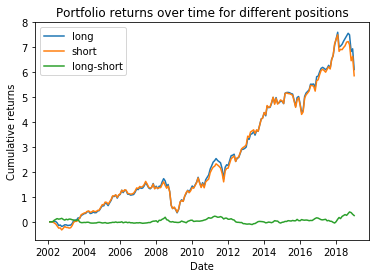

In [29]:
plt.plot((1+long.set_index("date").Return).cumprod()-1, label='long')
plt.plot((1+(-1*short.set_index("date").Return)).cumprod()-1, label='short')
plt.plot(((1+long.set_index("date").Return).cumprod()-1)-((1+(-1*short.set_index("date").Return)).cumprod()-1),label='long-short')
plt.title("Portfolio returns over time for different positions")
plt.ylabel("Cumulative returns")
plt.xlabel("Date")
plt.legend()
plt.show()

#### Answer 3.1

In [30]:
total_ret = long.iloc[-1].Total + short.iloc[-1].Total
print("Total return: €{:>8.2f}".format(total_ret))

Total return: €  517.29


#### Answer 3.2

In [31]:
ann_avg_ret = total_ret / len(long.set_index("date").resample('Y').mean())
print("Annual average return: €{:>8.2f}".format(ann_avg_ret))

Annual average return: €   30.43
